In [85]:
from typing import Callable, NamedTuple
from dataclasses import dataclass
from itertools import product, chain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [86]:
ds = datasets.MNIST(
    root='data',
    train=True,
    download=True,

    transform=lambda img: torch.Tensor(np.asarray(img).flatten())/256,
    target_transform=lambda x: torch.Tensor(
        [1 if i == x else 0 for i in range(10)])
)
dl = {
    'test': DataLoader(Subset(ds, range(0, 1024)), shuffle=True, batch_size=16),
    'train': DataLoader(Subset(ds, range(1024, 1024+512+1)), shuffle=True, batch_size=16),
}

In [87]:
@dataclass
class HyperParams:
    lr: float
    epochs: int
    # inner_layers: int

    def __init__(self, lr, epoch):
        epoch = int(epoch)
        assert lr > 0
        assert epoch > 0
        self.lr = lr
        self.epochs = int(epoch)

    def to_vec(self):
        return np.array([
            self.lr, self.epochs
        ])


MUTAGENS = [
    (0.0001, 0.001),
    (10, 60),
]

In [88]:
class Creature:
    model: torch.nn.Sequential
    optimizer: torch.optim.Adam
    hp: HyperParams
    criterion: torch.nn.Module

    def __init__(self, hp: HyperParams):
        self.hp = hp
        self.criterion = torch.nn.MSELoss()

        layers = []
        # первый слой
        layers.append(torch.nn.Linear(784, 128))
        layers.append(torch.nn.ReLU())

        # скрытые слои
        layers.append(torch.nn.Linear(128, 128))
        layers.append(torch.nn.ReLU())

        # последний слой
        layers.append(torch.nn.Linear(128, 10))
        layers.append(torch.nn.ReLU())

        layers.append(torch.nn.Softmax())

        self.model = torch.nn.Sequential(*layers)

        self.optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.hp.lr)

    def __repr__(self):
        return str(self.hp)

    def train(self, dl: DataLoader):
        for _ in range(self.hp.epochs):
            for X, y in dl:
                outputs = self.model(X)
                loss = self.criterion(outputs, y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def test(self, dl: DataLoader):
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in dl:
                outputs = self.model(X)
                preds = torch.argmax(outputs, dim=1)
                y = torch.argmax(y, dim=1)
                correct += torch.eq(preds, y).sum().item()
                total += len(y)
        return correct/total

    def fitnes(self, dl: DataLoader):
        return self.test(dl)
        def mu(x, y): return 1/self.criterion(x, y)
        with torch.no_grad():
            return sum([mu(self.model(x), y) for x, y in dl]).item()

In [89]:
np.linspace(0.001, 0.5, 6, True)

array([0.001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5   ])

In [90]:
class Zoo:
    creatures: list[Creature]
    dl: dict[str, DataLoader]
    pop_size: int
    df: pd.DataFrame

    def __init__(self, dl_len=1000) -> None:
        self.dl = {
            'test': DataLoader(Subset(ds, range(0, dl_len)), shuffle=True, batch_size=16),
            'train': DataLoader(Subset(ds, range(dl_len, int(dl_len*1.2))), shuffle=True, batch_size=16),
        }

        lrs = [0.000085, 0.00013, 0.0002, 0.0008, 0.008]
        epochs = [20, 40, 60]
        # print(lrs)
        # print(epochs)
        # lrs = [0.01, 0.05]
        # epochs = [15, 30]

        self.creatures = []
        self.pop_size = 0
        for lr, ep_num in product(lrs, epochs):
            self.creatures.append(Creature(HyperParams(lr=lr, epoch=ep_num)))
            self.pop_size += 1

    def train(self):
        for c in tqdm(self.creatures):
            c.train(self.dl['train'])

    def build_df(self, creatures: list[Creature]):
        df = pd.DataFrame({'creature': creatures})
        # df['accuracy'] = df.creature.map(lambda x: x.test(self.dl['test']))
        df['fitnes'] = df.creature.map(lambda x: x.fitnes(self.dl['test']))
        df.fitnes = df.fitnes
        df['cs'] = df.fitnes / df.fitnes.sum()
        df['cs'] = df['cs'] / sum(df.cs)
        df = df.sort_values(by=['fitnes'], axis=0, ascending=True)
        return df

    def selection(self):
        self.creatures = list(np.random.choice(
            self.df.creature,
            size=self.pop_size,
            p=self.df.cs
        ))

    def crossing_over(self):
        def cross(p1, p2):
            pc = 0.7
            genes1, genes2 = p1.hp.to_vec(), p2.hp.to_vec()
            while True:
                try:
                    ngenes1, ngenes2 = [], []
                    for g1, g2 in zip(genes1, genes2):
                        r = np.random.random()
                        if r < pc:
                            ngenes1.append(g1)
                            ngenes2.append(g2)
                        else:
                            c = np.random.random()
                            ngenes1.append(g1*c + (1-c)*g2)
                            ngenes2.append(g2*c + (1-c)*g1)
                except AssertionError:
                    continue
                else:
                    return [Creature(HyperParams(*ngenes1)), Creature(HyperParams(*ngenes2))]

        np.random.shuffle(self.creatures)  # type: ignore
        pairs = [tuple(self.creatures[i:i+2]) for i in range(0, 2*len(self.creatures)//2-1, 2)] + \
            [tuple(self.creatures[-2:])]
        offsprings = list(map(lambda x: cross(*x), pairs))
        self.creatures = list(chain(*offsprings))[:self.pop_size]

    def mutation(self):
        pm = 0.4

        def mutate(c):
            if np.random.random() > pm:
                return c
            gens = c.hp.to_vec()
            i = np.random.randint(0, len(gens))
            gens[i] = np.random.uniform(*MUTAGENS[i])
            try:
                return Creature(HyperParams(*gens))
            except:
                return c

        self.creatures = list(map(mutate, self.creatures))

    def replace_with_new_gen(self):
        # print('-----------------')
        new_df = self.build_df(self.creatures)
        # print(self.df)
        # print(new_df)

        all_df = pd.concat([self.df, new_df], axis=0)
        all_df.fitnes
        all_df.sort_values(by='fitnes', ascending=True, inplace=True)
        # print(all_df)
        self.df = all_df.tail(self.pop_size)
        self.df.cs = self.df.fitnes / self.df.fitnes.sum()
        print(self.df)

    def evolve(self, N):
        best = []
        self.train()
        self.df = self.build_df(self.creatures)
        # эволюционируем
        for i in range(N):
            print(f'-> generation {i+1} of {N}')
            self.selection()
            self.crossing_over()
            self.mutation()
            self.train()
            self.replace_with_new_gen()
            best.append(self.df.iloc[-1].fitnes)
            # print(self.df)

        # результат

        print(self.df)
        row = self.df['fitnes'].idxmax()

        plt.plot(range(len(best)), best)
        return self.df.iloc[row].creature, self.df.iloc[row].fitnes

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:46<00:00,  3.09s/it]


-> generation 1 of 10


100%|██████████| 15/15 [00:44<00:00,  2.93s/it]


                                             creature  fitnes        cs
2   HyperParams(lr=0.00013327370866832248, epochs=60)   0.529  0.057344
7                   HyperParams(lr=0.0002, epochs=40)   0.533  0.057778
13  HyperParams(lr=0.00034817999854094833, epochs=49)   0.557  0.060379
3                  HyperParams(lr=0.00013, epochs=20)   0.568  0.061572
7   HyperParams(lr=0.00013323136573431942, epochs=60)   0.592  0.064173
1                  HyperParams(lr=8.5e-05, epochs=40)   0.597  0.064715
5     HyperParams(lr=0.004094574513128657, epochs=16)   0.598  0.064824
11                  HyperParams(lr=0.0008, epochs=60)   0.609  0.066016
14                  HyperParams(lr=0.0002, epochs=35)   0.621  0.067317
6   HyperParams(lr=0.00017778606040570903, epochs=40)   0.638  0.069160
9                  HyperParams(lr=0.00013, epochs=60)   0.656  0.071111
8                   HyperParams(lr=0.0002, epochs=60)   0.671  0.072737
6                   HyperParams(lr=0.0002, epochs=20)   0.679  0

100%|██████████| 15/15 [00:56<00:00,  3.79s/it]


                                             creature  fitnes        cs
6                  HyperParams(lr=0.00013, epochs=60)   0.600  0.061671
14                 HyperParams(lr=0.00013, epochs=60)   0.606  0.062288
11                  HyperParams(lr=0.0008, epochs=60)   0.609  0.062596
1    HyperParams(lr=0.0007165291015036551, epochs=54)   0.618  0.063521
14                  HyperParams(lr=0.0002, epochs=35)   0.621  0.063830
6   HyperParams(lr=0.00017778606040570903, epochs=40)   0.638  0.065577
13                 HyperParams(lr=0.00013, epochs=60)   0.656  0.067427
9                  HyperParams(lr=0.00013, epochs=60)   0.656  0.067427
4    HyperParams(lr=0.0001509242640013631, epochs=40)   0.662  0.068044
9                  HyperParams(lr=0.00013, epochs=60)   0.664  0.068250
8                   HyperParams(lr=0.0002, epochs=60)   0.671  0.068969
3                   HyperParams(lr=0.0002, epochs=48)   0.672  0.069072
6                   HyperParams(lr=0.0002, epochs=20)   0.679  0

100%|██████████| 15/15 [00:52<00:00,  3.52s/it]


                                             creature  fitnes        cs
6   HyperParams(lr=0.00017778606040570903, epochs=40)   0.638  0.062826
8    HyperParams(lr=0.0004422105966561158, epochs=60)   0.649  0.063909
9                  HyperParams(lr=0.00013, epochs=60)   0.656  0.064599
13                 HyperParams(lr=0.00013, epochs=60)   0.656  0.064599
6                  HyperParams(lr=0.00013, epochs=22)   0.656  0.064599
4    HyperParams(lr=0.0001509242640013631, epochs=40)   0.662  0.065190
9                  HyperParams(lr=0.00013, epochs=60)   0.664  0.065387
8                   HyperParams(lr=0.0002, epochs=60)   0.671  0.066076
3                   HyperParams(lr=0.0002, epochs=48)   0.672  0.066174
6                   HyperParams(lr=0.0002, epochs=20)   0.679  0.066864
3                   HyperParams(lr=0.0002, epochs=60)   0.685  0.067454
5                  HyperParams(lr=0.00013, epochs=60)   0.692  0.068144
1                  HyperParams(lr=0.00013, epochs=60)   0.696  0

100%|██████████| 15/15 [01:00<00:00,  4.01s/it]


                                             creature  fitnes        cs
8    HyperParams(lr=0.0004422105966561158, epochs=60)   0.649  0.063004
6                  HyperParams(lr=0.00013, epochs=22)   0.656  0.063683
13                 HyperParams(lr=0.00013, epochs=60)   0.656  0.063683
9                  HyperParams(lr=0.00013, epochs=60)   0.656  0.063683
4    HyperParams(lr=0.0001509242640013631, epochs=40)   0.662  0.064266
9                  HyperParams(lr=0.00013, epochs=60)   0.664  0.064460
8                   HyperParams(lr=0.0002, epochs=60)   0.671  0.065139
3                   HyperParams(lr=0.0002, epochs=48)   0.672  0.065236
6                   HyperParams(lr=0.0002, epochs=20)   0.679  0.065916
3                   HyperParams(lr=0.0002, epochs=60)   0.685  0.066498
5                  HyperParams(lr=0.00013, epochs=60)   0.692  0.067178
1                  HyperParams(lr=0.00013, epochs=60)   0.696  0.067566
5    HyperParams(lr=0.0005130459678931662, epochs=60)   0.731  0

100%|██████████| 15/15 [01:01<00:00,  4.10s/it]


                                             creature  fitnes        cs
4    HyperParams(lr=0.0001509242640013631, epochs=40)   0.662  0.062743
0                  HyperParams(lr=0.00013, epochs=31)   0.663  0.062838
9                  HyperParams(lr=0.00013, epochs=60)   0.664  0.062932
8                   HyperParams(lr=0.0002, epochs=60)   0.671  0.063596
3                   HyperParams(lr=0.0002, epochs=48)   0.672  0.063691
6                   HyperParams(lr=0.0002, epochs=20)   0.679  0.064354
3                   HyperParams(lr=0.0002, epochs=60)   0.685  0.064923
5                  HyperParams(lr=0.00013, epochs=60)   0.692  0.065586
7   HyperParams(lr=0.00016497122092409375, epochs=40)   0.693  0.065681
1                  HyperParams(lr=0.00013, epochs=60)   0.696  0.065965
12   HyperParams(lr=0.0007710583387554505, epochs=60)   0.729  0.069093
5    HyperParams(lr=0.0005130459678931662, epochs=60)   0.731  0.069283
4   HyperParams(lr=0.00016497122092409375, epochs=40)   0.748  0

100%|██████████| 15/15 [00:51<00:00,  3.46s/it]


                                             creature  fitnes        cs
9                  HyperParams(lr=0.00013, epochs=60)   0.664  0.062713
1    HyperParams(lr=0.0008651579871384515, epochs=40)   0.671  0.063374
8                   HyperParams(lr=0.0002, epochs=60)   0.671  0.063374
3                   HyperParams(lr=0.0002, epochs=48)   0.672  0.063468
6                   HyperParams(lr=0.0002, epochs=20)   0.679  0.064129
3                   HyperParams(lr=0.0002, epochs=60)   0.685  0.064696
9   HyperParams(lr=0.00043248962449108876, epochs=44)   0.691  0.065263
5                  HyperParams(lr=0.00013, epochs=60)   0.692  0.065357
7   HyperParams(lr=0.00016497122092409375, epochs=40)   0.693  0.065451
1                  HyperParams(lr=0.00013, epochs=60)   0.696  0.065735
12   HyperParams(lr=0.0007710583387554505, epochs=60)   0.729  0.068852
5    HyperParams(lr=0.0005130459678931662, epochs=60)   0.731  0.069040
4   HyperParams(lr=0.00016497122092409375, epochs=40)   0.748  0

100%|██████████| 15/15 [00:51<00:00,  3.45s/it]


                                             creature  fitnes        cs
1    HyperParams(lr=0.0008651579871384515, epochs=40)   0.671  0.062792
3                   HyperParams(lr=0.0002, epochs=48)   0.672  0.062886
7    HyperParams(lr=0.0004797851505859555, epochs=60)   0.675  0.063167
6                   HyperParams(lr=0.0002, epochs=20)   0.679  0.063541
3                   HyperParams(lr=0.0002, epochs=60)   0.685  0.064103
9   HyperParams(lr=0.00043248962449108876, epochs=44)   0.691  0.064664
5                  HyperParams(lr=0.00013, epochs=60)   0.692  0.064758
7   HyperParams(lr=0.00016497122092409375, epochs=40)   0.693  0.064851
1                  HyperParams(lr=0.00013, epochs=60)   0.696  0.065132
12   HyperParams(lr=0.0007710583387554505, epochs=60)   0.729  0.068220
5    HyperParams(lr=0.0005130459678931662, epochs=60)   0.731  0.068407
4   HyperParams(lr=0.00016497122092409375, epochs=40)   0.748  0.069998
4   HyperParams(lr=0.00016497122092409375, epochs=40)   0.758  0

100%|██████████| 15/15 [00:42<00:00,  2.86s/it]


                                             creature  fitnes        cs
7    HyperParams(lr=0.0004797851505859555, epochs=60)   0.675  0.062575
6                   HyperParams(lr=0.0002, epochs=20)   0.679  0.062946
3                   HyperParams(lr=0.0002, epochs=60)   0.685  0.063502
9   HyperParams(lr=0.00043248962449108876, epochs=44)   0.691  0.064059
5                  HyperParams(lr=0.00013, epochs=60)   0.692  0.064151
7   HyperParams(lr=0.00016497122092409375, epochs=40)   0.693  0.064244
10  HyperParams(lr=0.00025659127637556775, epochs=27)   0.696  0.064522
1                  HyperParams(lr=0.00013, epochs=60)   0.696  0.064522
12   HyperParams(lr=0.0007710583387554505, epochs=60)   0.729  0.067581
5    HyperParams(lr=0.0005130459678931662, epochs=60)   0.731  0.067767
11   HyperParams(lr=0.0006956480734856922, epochs=40)   0.748  0.069343
4   HyperParams(lr=0.00016497122092409375, epochs=40)   0.748  0.069343
4   HyperParams(lr=0.00016497122092409375, epochs=40)   0.758  0

100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


                                             creature  fitnes        cs
5                  HyperParams(lr=0.00013, epochs=60)   0.692  0.062670
7   HyperParams(lr=0.00016497122092409375, epochs=40)   0.693  0.062760
1                  HyperParams(lr=0.00013, epochs=60)   0.696  0.063032
10  HyperParams(lr=0.00025659127637556775, epochs=27)   0.696  0.063032
12   HyperParams(lr=0.0007710583387554505, epochs=60)   0.729  0.066021
7    HyperParams(lr=0.0006956480734856922, epochs=31)   0.729  0.066021
3   HyperParams(lr=0.00016497122092409375, epochs=40)   0.731  0.066202
5    HyperParams(lr=0.0005130459678931662, epochs=60)   0.731  0.066202
0   HyperParams(lr=0.00042757598469973454, epochs=60)   0.735  0.066564
4   HyperParams(lr=0.00016497122092409375, epochs=40)   0.748  0.067741
11   HyperParams(lr=0.0006956480734856922, epochs=40)   0.748  0.067741
4   HyperParams(lr=0.00016497122092409375, epochs=40)   0.758  0.068647
10                  HyperParams(lr=0.0002, epochs=26)   0.782  0

100%|██████████| 15/15 [00:44<00:00,  2.97s/it]


                                             creature  fitnes        cs
5                  HyperParams(lr=0.00013, epochs=60)   0.692  0.062670
7   HyperParams(lr=0.00016497122092409375, epochs=40)   0.693  0.062760
10  HyperParams(lr=0.00025659127637556775, epochs=27)   0.696  0.063032
1                  HyperParams(lr=0.00013, epochs=60)   0.696  0.063032
7    HyperParams(lr=0.0006956480734856922, epochs=31)   0.729  0.066021
12   HyperParams(lr=0.0007710583387554505, epochs=60)   0.729  0.066021
5    HyperParams(lr=0.0005130459678931662, epochs=60)   0.731  0.066202
3   HyperParams(lr=0.00016497122092409375, epochs=40)   0.731  0.066202
0   HyperParams(lr=0.00042757598469973454, epochs=60)   0.735  0.066564
11   HyperParams(lr=0.0006956480734856922, epochs=40)   0.748  0.067741
4   HyperParams(lr=0.00016497122092409375, epochs=40)   0.748  0.067741
4   HyperParams(lr=0.00016497122092409375, epochs=40)   0.758  0.068647
10                  HyperParams(lr=0.0002, epochs=26)   0.782  0

(HyperParams(lr=0.0007710583387554505, epochs=60), 0.729)

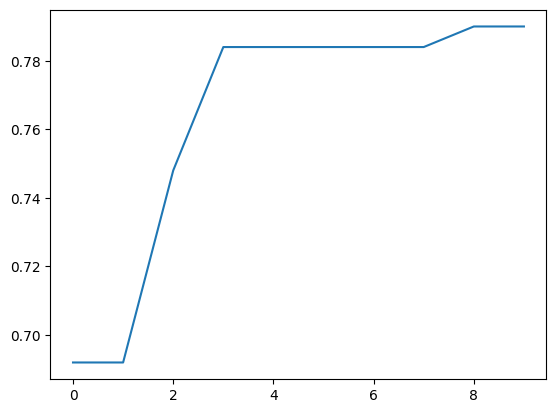

In [91]:
z = Zoo()
z.evolve(10)